# Libraries & Helpers

In [171]:
# Libraries
import pandas as pd
import numpy as np
import gspread
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")  
from src import config
from src import help_functions as hf

# Configs
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Data

In [172]:
# Import and quick check Training data 
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[0], sheet_index=0)

# "Clean" data
for col in training_data.columns:
    try:
        training_data[col] = training_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
training_data["Date"] = pd.to_datetime(training_data[["Year", "Month", "Day"]]).dt.date
training_data["Datetime"] = pd.to_datetime(training_data[["Year", "Month", "Day"]])
training_data = training_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Training data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(training_data["Date"].min(), training_data["Date"].max()))
print("Duplicated rows = {}".format(training_data[training_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=training_data["Date"].min(), end=training_data["Date"].max()).date if d not in training_data["Date"].values]))

print("\nDifferent activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    training_data
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Training data about:
-----------------------------------------------------
Todays date: 2025-08-30
Date range: 2024-09-13 to 2025-08-29
Duplicated rows = 0
Missing dates = []

Different activities and their counts:
-------------------------------------
Trail Running ~> 285.94 hours (154 act.)
Road Biking ~> 78.77 hours (32 act.)
Running ~> 78.25 hours (76 act.)
Indoor Biking ~> 71.04 hours (51 act.)
Mountain Biking ~> 16.99 hours (9 act.)
Hiking ~> 15.35 hours (6 act.)
Road biking ~> 3.74 hours (2 act.)
Lap Swimming ~> 0.21 hours (1 act.)


In [173]:
# Import and quick check Daily data
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
daily_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[1], sheet_index=0)

# "Clean" data
for col in daily_data.columns:
    try:
        daily_data[col] = daily_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]]).dt.date
daily_data["Datetime"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])
daily_data = daily_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Daily data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(daily_data["Date"].min(), daily_data["Date"].max()))
print("Duplicated rows = {}".format(daily_data[daily_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_data["Date"].min(), end=daily_data["Date"].max()).date if d not in daily_data["Date"].values]))

Daily data about:
-----------------------------------------------------
Todays date: 2025-08-30
Date range: 2024-04-15 to 2025-08-29
Duplicated rows = 0
Missing dates = []


# Goals

We have two goals:

1. **Recent Adjusted Relative Training Load (ARTL)**

Define a simple metric that shows where we are with our current training compared to what we've been doing in the recent past. The purpose is to see if we should reduce out trainings load — so that we don't overreach or risk injury, or increase increase it to match what what our body has been adapted to in recent past. Or just simple define where in the training cycle we are if we take larger picture into account. *How are we positined relative to recent training load overall?*

2. **Recent Load Relative Percentile (RLRP)**

Quantify how hard today's training was compared to what we are used to. In other words, show where this session fall within the distribution of our recent sessions — is it an average day, a light day, or a clear spike? This also helps guide tomorrow’s (or few next days) training choice, since we know whether today was relatively light, normal, or heavy.

Dataset:

- All activities, regardless if it was real training or not (including hiking, swimming, easy cycling etc.).
- Lets assume we only have one "real" workout per day and take total (sum) daily training load (one sample is one day). 

Let $TL_i$ be the training load of the day i.

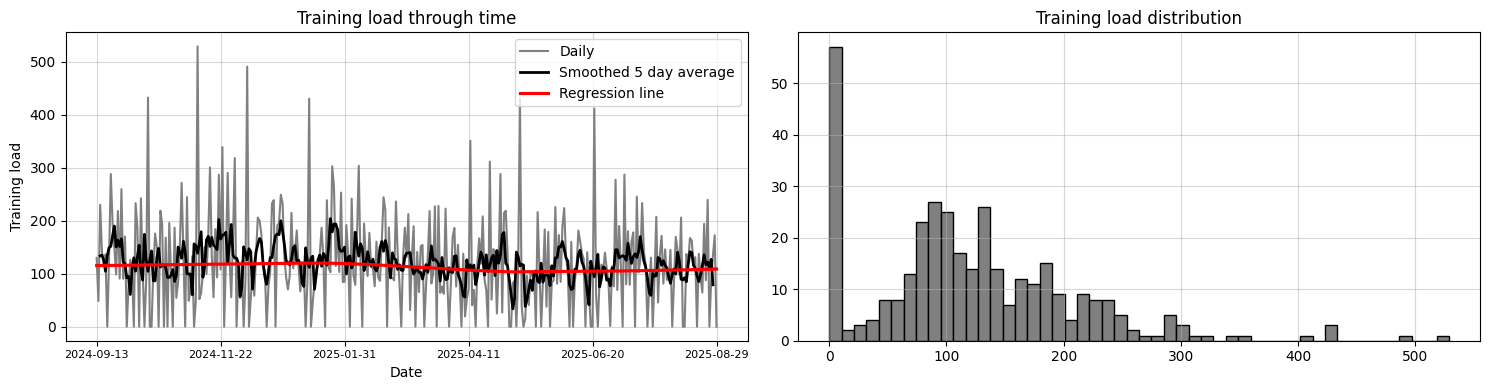

    Datetime  Training load                     Description
0 2025-04-12          350.6        Race Zalec Trail Running
1 2025-06-21          411.3       Race Tolmin Trail Running
2 2025-01-11          430.0      Race Nazarje Trail Running
3 2025-05-10          430.8       Race Idrija Trail Running
4 2024-10-12          431.9        Race Zalec Trail Running
5 2024-12-07          490.3      Race Velenje Trail Running
6 2024-11-09          528.6  Race Nova Gorica Trail Running


In [174]:
# Data:

rtl_data = (
    training_data
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Activity type": lambda x: " | ".join(map(str, x)),  
        "Description": lambda x: " | ".join(x)  
    })
    .reset_index()
    .assign(**{"Date index": lambda x: np.arange(x.shape[0])[::-1] + 1})
    # [["Date", "Training load"]]
)

# Exploratory data analysis - EDA
fig, ax = plt.subplots(1,2,figsize=(15, 4))
indices = np.arange(rtl_data.shape[0])

# Training load trough time
ax[0].set_title("Training load through time")
ax[0].plot(indices, rtl_data["Training load"], color="grey", label="Daily")
ax[0].plot(indices, rtl_data["Training load"].rolling(window=5, center=True).mean(), color="black", label="Smoothed 5 day average", linewidth=2)
sns.regplot(x=indices, y=rtl_data["Training load"], scatter=False, lowess=True, color="red", label="Regression line", ax=ax[0])
ax[0].legend()

ax[0].set_xticks(indices[::max(1, len(indices)//5)])  
ax[0].set_xticklabels(rtl_data["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Training load")

# Training load distribution
ax[1].set_title("Training load distribution")
ax[1].hist(rtl_data["Training load"], bins=50, color="grey", edgecolor="black")

for i in [0,1]:
    ax[i].grid(alpha=.5)
        
plt.tight_layout()
plt.show()

print(
    rtl_data
    .sort_values("Training load")
    [["Datetime", "Training load", "Description"]]
    .tail(7)
    .reset_index(drop=True)
)



# History-Aware Stratified Relative Training Load (HASRTL)
---
---

### Idea

When training for endurance sports, our bodies adapt over time, and whether a workout is "hard" or "easy" on the body, depends on what we’ve been doing recently and historically. To capture this, we want a **history-aware measure of current relative load**, which compares recent training to what the body has been successfully adapted to over a longer period.

We can think of this in two complementary components:

- Baseline (long term) adaptation - Load your body has been (succesfully) adapted to over a longer period, disregarding recent acute load.
    - Denoted as $TL_{\text{baseline},t}$.
    - Computed over a long baseline window of $N$ =  90 days (3 months), excluding last $n$ = 14 days (2 weeks): $\mathcal{L}_t=\{TL_{t-i}\mid i=n+1,\dots,n+N\}$ 
- Recent training pattern - Load our body is being exposed to in the recent window - reflects acute training load.
    - Denotes $TL_{\text{recent},t}$.
    - Computed over a recent window of $n$ = 14 days (2 weeks): $\mathcal{R}_t=\{TL_{t-i}\mid i=1,\dots,n\}$ .

In [308]:
# Define parameters
baseline_window = 90
recent_window = 14

### Percentile stratified metric

In endurance sports, training days (including races) can be grouped into a few main types:
- **Easy & medium long sessions** - used for recovery, aerobic base, and technique work. These make up roughly 70% of all sessions.
- **Hard sessions** - tempo, threshold, VO2max, or interval workouts. Typically around 20% of sessions.
- **Long days** - the occasional very long run, bike ride, or race that forms the extreme right tail of the distribution. About 10% of sessions.
- **Other** - longer bike days, longer hikes, multiple activities in one day etc.
- **Rest days** - no training at all.

In [296]:
# Define easy, hard and long days ~ cca (hard to trully distinct them)
rtl_data["easy_hard_long_description"] = pd.Series(dtype="object")

# Rest days
rest_mask = rtl_data["Description"] == "Rest"
rtl_data.loc[rest_mask, "easy_hard_long_description"] = "rest"

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"].str.contains("Running|Workout|Biking|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) &
    ~(rtl_data["Description"].str.contains("Race", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[easy_mask, "easy_hard_long_description"] = "easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"] .str.contains("INT|TT|PWH|LT|x")) &
    ~(rtl_data["Description"].str.contains("Running|Biking|Workout|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[hard_mask, "easy_hard_long_description"] = "hard"

# Long days (No special description, duration >= 2h)
long_mask = (
    (rtl_data["Duration [h]"] >= 2.0)  &
    (rtl_data["Description"].str.contains("Running|Dolgi|Tek|x", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[long_mask, "easy_hard_long_description"] = "long"

# Other (medium long days, other ...)
other_mask = (
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[other_mask, "easy_hard_long_description"] = "other"

In [297]:
# About
print("Easy, hard, long days - description:")
print("-----------------------------------------------------")
for value in ["easy", "hard", "long", "other", "rest"]:
    data_tmp = rtl_data.query("easy_hard_long_description == @value")
    print("{} ~> {} ({}% | *{}%) ~> [mean = {}, SD = {}]".format(
        value, 
        data_tmp.shape[0],
        round(data_tmp.shape[0]/rtl_data.shape[0] * 100, 2),
        round(data_tmp.shape[0]/rtl_data.query("easy_hard_long_description != 'rest'").shape[0] * 100, 2),
        round(data_tmp["Training load"].mean(), 2),
        round(data_tmp["Training load"].std(), 2)
        ))
print("* ~> Without rest days included in proportions")

Easy, hard, long days - description:
-----------------------------------------------------
easy ~> 164 (46.72% | *54.3%) ~> [mean = 95.94, SD = 43.45]
hard ~> 51 (14.53% | *16.89%) ~> [mean = 189.76, SD = 56.21]
long ~> 65 (18.52% | *21.52%) ~> [mean = 217.48, SD = 97.5]
other ~> 22 (6.27% | *7.28%) ~> [mean = 133.35, SD = 69.5]
rest ~> 49 (13.96% | *16.23%) ~> [mean = 0.0, SD = 0.0]
* ~> Without rest days included in proportions


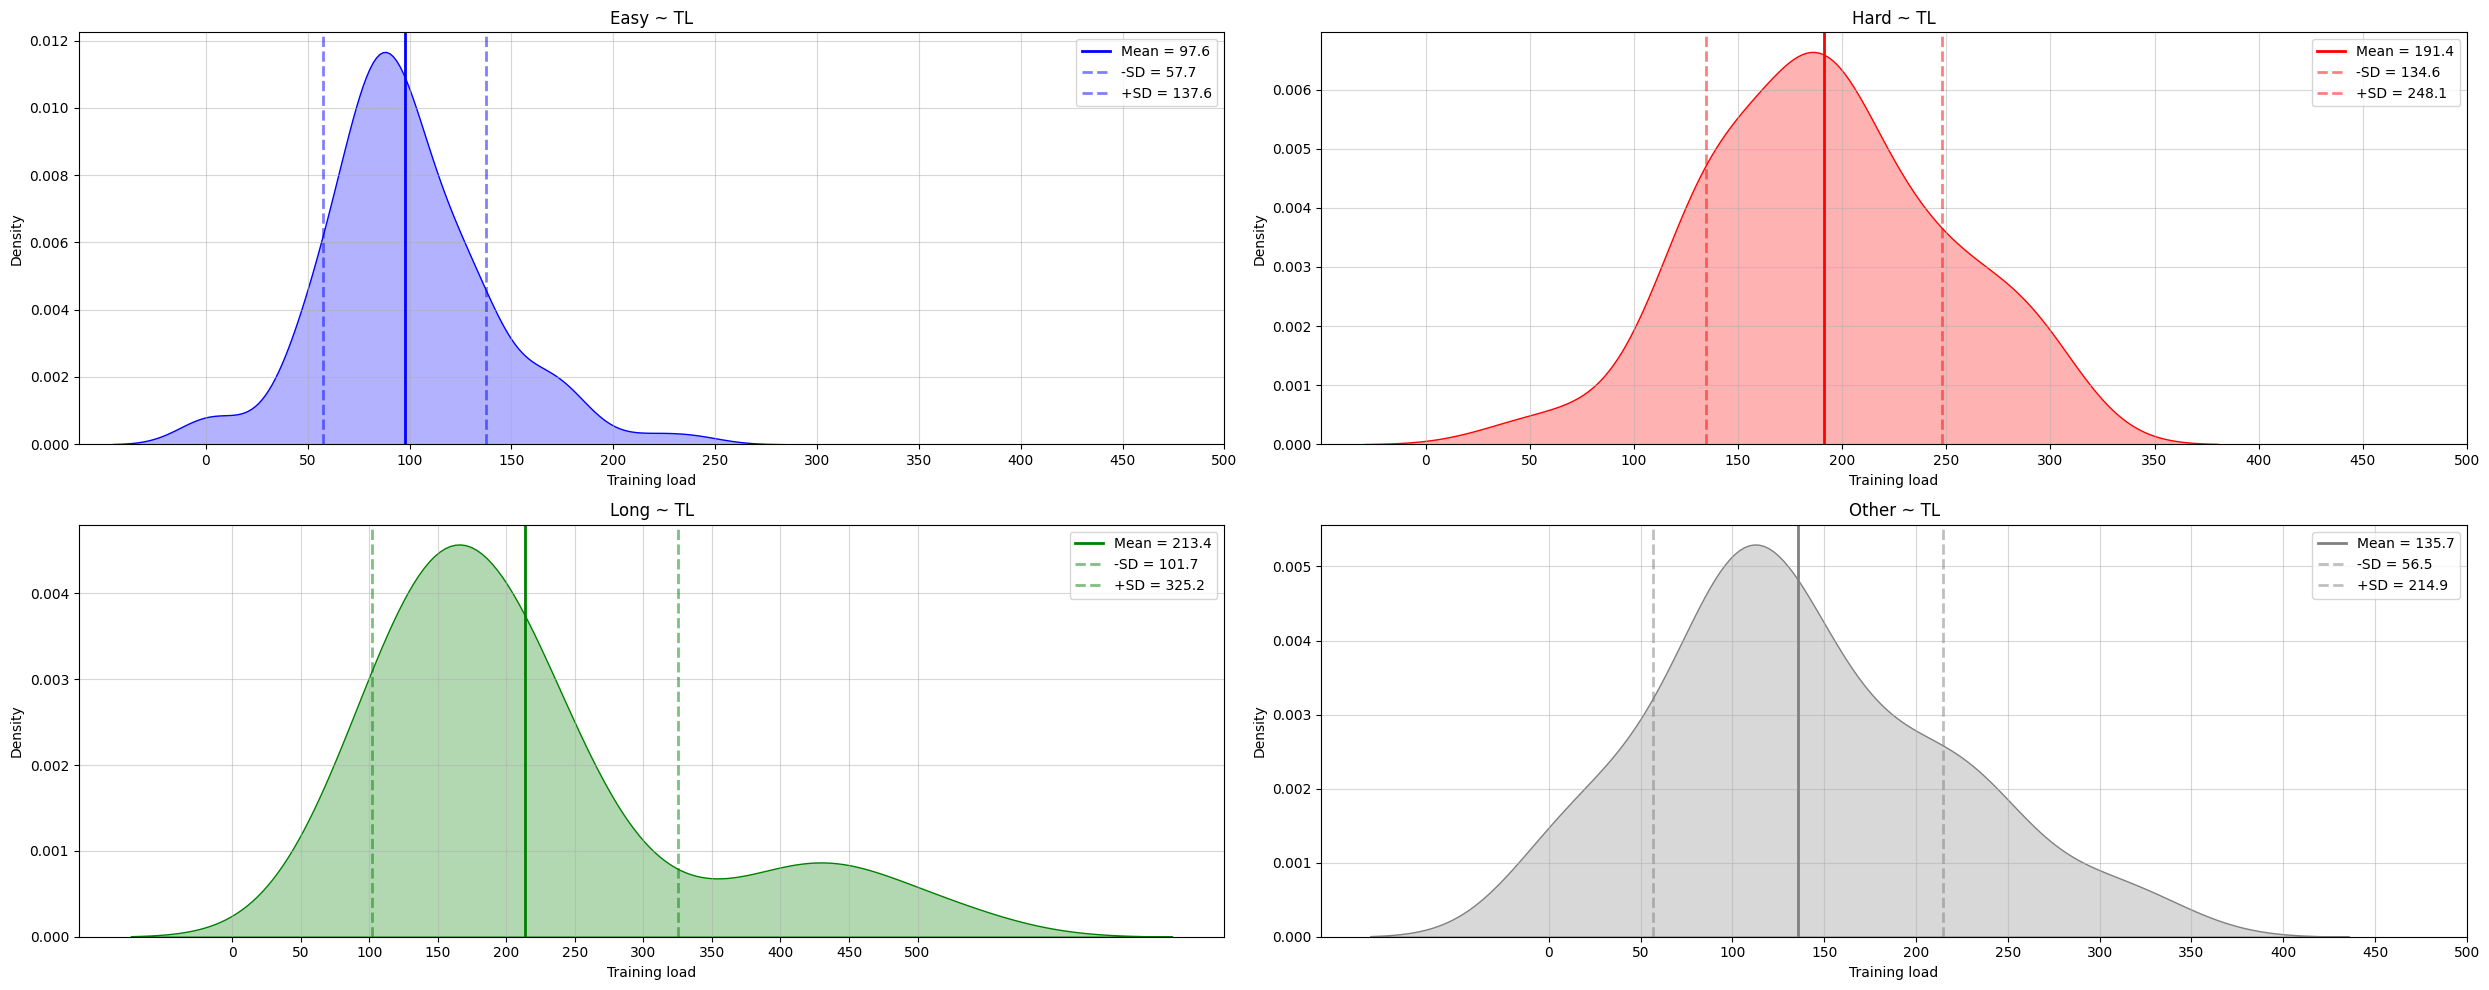

In [265]:
# Plot 1
fig, ax = plt.subplots(2,2,figsize=(25, 10))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

ax[0,0].set_title("Easy ~ TL")
easy_tmp = rtl_data.query("easy_hard_long_description == 'easy'")["Training load"]
sns.kdeplot(easy_tmp, color="blue", fill=True, alpha=0.3, ax=ax[0,0])
ax[0,0].axvline(easy_tmp.mean(), color="blue", linestyle="-", linewidth=2, label=f"Mean = {easy_tmp.mean():.1f}")
ax[0,0].axvline(easy_tmp.mean() - easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {easy_tmp.mean() - easy_tmp.std():.1f}")
ax[0,0].axvline(easy_tmp.mean() + easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {easy_tmp.mean() + easy_tmp.std():.1f}")

ax[0,1].set_title("Hard ~ TL")
hard_tmp = rtl_data.query("easy_hard_long_description == 'hard'")["Training load"]
sns.kdeplot(hard_tmp, color="red", fill=True, alpha=0.3, ax=ax[0,1])
ax[0,1].axvline(hard_tmp.mean(), color="red", linestyle="-", linewidth=2, label=f"Mean = {hard_tmp.mean():.1f}")
ax[0,1].axvline(hard_tmp.mean() - hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {hard_tmp.mean() - hard_tmp.std():.1f}")
ax[0,1].axvline(hard_tmp.mean() + hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {hard_tmp.mean() + hard_tmp.std():.1f}")

ax[1,0].set_title("Long ~ TL")
long_tmp = rtl_data.query("easy_hard_long_description == 'long'")["Training load"]
sns.kdeplot(long_tmp, color="green", fill=True, alpha=0.3, ax=ax[1,0])
ax[1,0].axvline(long_tmp.mean(), color="green", linestyle="-", linewidth=2, label=f"Mean = {long_tmp.mean():.1f}")
ax[1,0].axvline(long_tmp.mean() - long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {long_tmp.mean() - long_tmp.std():.1f}")
ax[1,0].axvline(long_tmp.mean() + long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {long_tmp.mean() + long_tmp.std():.1f}")

ax[1,1].set_title("Other ~ TL")
other_tmp = rtl_data.query("easy_hard_long_description == 'other'")["Training load"]
sns.kdeplot(other_tmp, color="grey", fill=True, alpha=0.3, ax=ax[1,1])
ax[1,1].axvline(other_tmp.mean(), color="grey", linestyle="-", linewidth=2, label=f"Mean = {other_tmp.mean():.1f}")
ax[1,1].axvline(other_tmp.mean() - other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {other_tmp.mean() - other_tmp.std():.1f}")
ax[1,1].axvline(other_tmp.mean() + other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {other_tmp.mean() + other_tmp.std():.1f}")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))
        ax[i,j].grid(alpha=.5)
        ax[i,j].legend()

plt.tight_layout()
plt.show()

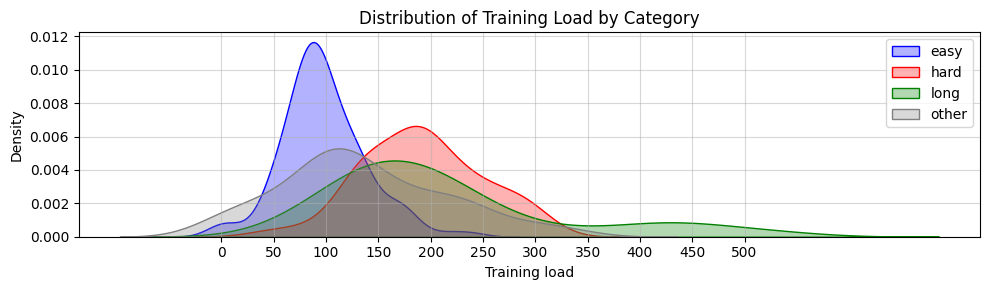

In [269]:
# Plot 2
fig, ax = plt.subplots(1,1, figsize=(10,3))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

for cat in categories:
    tmp = rtl_data.query("easy_hard_long_description == @cat")["Training load"]
    color = colors[cat]
    sns.kdeplot(tmp, color=color, fill=True, alpha=0.3, ax=ax, label=cat)

ax.set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))

ax.set_xlabel("Training load")
ax.set_ylabel("Density")
ax.set_title("Distribution of Training Load by Category")
ax.legend()

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Now, to create a history-aware measure of current relative load, we have to take into account all of these three types of sessions, as they all contribute to our overall training load and adaptation, each in their own way. 
- Even though **easy and medium-long** sessions are individually low-stress, small increases in duration, intensity, or frequency can gradually accumulate, potentially pushing the body beyond its adapted baseline. They also form the foundation for recovery and adaptation from harder sessions, so they should not be too long, too intense, or too rare, ensuring that we can perform well in harder workouts.
- **Hard sessions** are important for performance improvement but carry higher risk of fatigue and overreaching. By tracking them separately, we can see if recent hard sessions exceed what the body is adapted to, indicating higher acute load. They should also make up a reasonable portion of total sessions to allow sufficient recovery.
- **Long days** are infrequent but highly taxing. Monitoring their frequency and intensity relative to baseline ensures they are not too frequent or extreme, reducing risk of excessive fatigue or injury.

We will divide all sessions into these three categories based on Training Load percentiles inside a rolling window (separately for baseline and recent windows). We use percentiles to classify sessions because this approach is individualized, automatic, and reproducible. Manually assigning sessions to categories would be impractical and inconsistent. 

- Let $\mathcal{Q}_p(\mathcal{L}_t)$ be $p$-th quantile of $\mathcal{L}_t$ and
- $\mathcal{Q}_p(\mathcal{R}_t)$ be $p$-th quantile of $\mathcal{R}_t$

We will use the following cutpoints:
- **Easy sessions**: Below the 70th percentile of training load within the window.
    - Baseline: $TL \leq q_{70,t}=Q_{0.70}(\mathcal{L}_t)$
    - Recent: $TL \leq r_{70,t}=Q_{0.70}(\mathcal{R}_t)$
- **Hard sessions**: Between the 70th and 90th percentiles of training load within the window.
    - Baseline: $q_{70,t} < $ TL $\leq q_{90,t}=Q_{0.90}(\mathcal{L}_t)$
    - Recent: $r_{70,t} < $ TL $\leq r_{90,t}=Q_{0.90}(\mathcal{R}_t)$
- **Long days**: Above the 90th percentile of training load within the window.
    - Baseline: $TL > q_{90,t}=Q_{0.90}(\mathcal{L}_t)$
    - Recent: $TL > r_{90,t}=Q_{0.90}(\mathcal{R}_t)$

Having defined these buckets, we summarize each bucket by the average training load within, and thus make the metric sensitive to shifts in the typical intensity of each type of session within the bucket.

**Baseline bucket averages:**
- Easy: $\mu_{1,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{L}_t,\; TL \le q_{70,t}\,]$
- Hard: $\mu_{2,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{L}_t,\; q_{70,t} < TL \le q_{90,t}\,]$
- Long: $\mu_{3,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{L}_t,\; TL > q_{90,t}\,]$

**Recent bucket averages:**
- Easy: $\nu_{1,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{R}_t,\; TL \le r_{70,t}\,]$
- Hard: $\nu_{2,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{R}_t,\; r_{70,t} < TL \le r_{90,t}\,]$
- Long: $\nu_{3,t} = \mathbb{E}[\,TL \mid TL \in \mathcal{R}_t,\; TL > r_{90,t}\,]$

In [329]:
# Calculate averages within each bucket for baseline rolling windows

rtl_data["baseline_b1_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[x <= x.quantile(0.7)].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

rtl_data["baseline_b2_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[(x > x.quantile(0.7)) & (x <= x.quantile(0.9))].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

rtl_data["baseline_b3_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[x > x.quantile(0.9)].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

In [332]:
# Calculate averages within each bucket for baseline rolling windows

rtl_data["recent_b1_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[x <= x.quantile(0.7)].mean(), raw=False)
)

rtl_data["recent_b2_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[(x > x.quantile(0.7)) & (x <= x.quantile(0.9))].mean(), raw=False)
)

rtl_data["recent_b3_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[x > x.quantile(0.9)].mean(), raw=False)
)

In [ ]:
# Incremental calculation ...


This division allows us to track recent load in a stratified way
- We can measure how the recent 2-week load compares to baseline separately for each bin.
- We can observe which type of sessions are driving increases or spikes — e.g., the easy sessions creeping up, or a cluster of recent long runs exceeding what the athlete has previously handled.
- This makes the metric sensitive to the composition of training.

Additionaly - option for furhter analysis, but we will talk more about this in some of next blogs: Once we have the bucket averages (for baseline or recent), we can use them to understand the structure and periodicity of the training program: Are the magnitudes of differences between buckets big enough, indicating the training distribution is appropriately stratified? Small differences could signal that the athlete is not creating meaningful variations in intensity or duration, which may limit adaptation.

Once we’ve divided training into these three buckets — we can combine them into a single history-aware metric that tells us how our recent load compares to what our body is adapted to. The idea is weighted aggregation.
- Each bucket contributes differently to the overall metric.
- For easy sessions, weight reflects their cumulative impact as they are frequent but individually low-stress.
- For hard sessions, weight reflects their intensity contribution as they are less frequent but more stressful.
- For long days, weight reflects their peak stress contribution as they are rare but can be very taxing.

By computing weighted averages of the per-bucket loads, we capture both the composition and magnitude of recent training relative to baseline. The resulting number — the History-Aware Stratified Relative Training Load (HASRTL) — allows us to compare recent load to our baseline adaptation while accounting for session type and weighting. HASRTL summarizes both frequency and intensity in a single, interpretable metric, while still allowing detailed inspection of each session type.